# Introduction to Astrometry Notebook

We're going to take sources from an HSC observation and match them to Gaia, look at the separations, then fit the wcs and look at  focal plane distortions, finally we'll look at the effect of proper motions, then apply proper motions and parallax and redo the fit. 

If that is too fast, also fit the source positions.
Potential extras: do a better fit using error of measurements, try to find bug in astropy proper motion.

#### First, load some helpful packages:

In [2]:
# Start by loading some helpful packages:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.wcs
import astropy.units as u
from astropy.io import fits
from astropy import wcs
import pandas as pd
from glob import glob
import re

Normally, I wouldn't recommend suppressing warning messages, but in this case astropy will complain a lot about the input files, so it's helpful here:

In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

## Part 1: Fitting a WCS

#### 1. Matching sources to a reference catalog

We start by loading the sample data sets. In the "astrometry_data" subdirectory, there are files containing the sources measured in one HSC exposure. There is one file for each detector. These source catalogs only contain isolated stars that are appropriate for fitting the astrometric solution (i.e., there are no galaxies or stars that are close to galaxies). There is also one file with a subset of the Gaia catalog overlapping the footprint of the HSC exposure.

First, load the Gaia catalog:

In [4]:
gaia_cat = pd.read_parquet('astrometry_data/gaia_refCat.parquet')
tmp_array = np.array([gaia_cat['coord_ra'], gaia_cat['coord_dec']]).T
print(tmp_array.shape)
np.savetxt('gaia_cat.dat', tmp_array)
good_ids = np.isfinite(gaia_cat['coord_ra'])
gaia_skyCoord = SkyCoord(gaia_cat[good_ids]['coord_ra'], gaia_cat[good_ids]['coord_dec'], unit=u.radian)

(13005, 2)


The files "astrometry_data/1180_\<detector\>.fits" contain the sources from each detector for visit 1180. The fits files have a best guess for the WCS in the primary HDU and the table of sources in the second HDU.

Let's start by just looking at one source catalog:

In [5]:
sources = fits.open('astrometry_data/1180_42.fits')
source_cat = sources[1].data
# Check the column names of the data:
print(source_cat.names)

['x', 'y', 'xErr', 'yErr']


Now convert the source catalog pixel values to RA and Dec using the WCS in the header

In [6]:
detector_wcs = wcs.WCS(sources[0].header)

source_skyCoord = detector_wcs.pixel_to_world(source_cat['x'], source_cat['y'])

Make a plot showing the RA and Dec positions of the two catalogs to make sure we are starting with something sensible. For example, first make sure that the RA and Dec values of the two catalogs overlap, which they should. (Mixing up degrees and radians happens all the time!) Does it look like there are any likely matches between the catalogs? I recommend using different markers for each catalog in your scatter plot.

(2.084237545773902, 2.176897995513615)

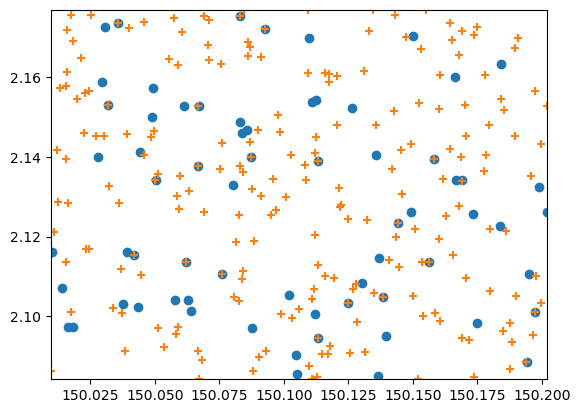

In [7]:
plt.scatter(gaia_skyCoord.ra, gaia_skyCoord.dec)
plt.scatter(source_skyCoord.ra, source_skyCoord.dec, marker='+')
plt.xlim(source_skyCoord.ra.degree.min(), source_skyCoord.ra.degree.max())
plt.ylim(source_skyCoord.dec.degree.min(), source_skyCoord.dec.degree.max())

Given the initial estimate of RA and Dec, match the Gaia catalog sources to the new source catalog:

In [8]:
# Complete: 
# (Hint: astropy SkyCoord has a "match_to_catalog_sky" function that works well for this.)
id, d2d, d3d = source_skyCoord.match_to_catalog_sky(gaia_skyCoord)

Not every source in the catalog will have a match in the Gaia catalog. Make a histogram of the match separations and choose a sensible limit for the distance between matches.

(array([21.,  0.,  1.,  4.,  4.,  5., 11.,  4.,  9., 20.,  8., 12., 12.,
        16.,  3., 10., 10., 10.,  6.,  9.,  7., 11.,  5.,  6.,  3.,  1.,
         3.,  4.,  0.,  1.]),
 array([6.90747594e-03, 2.17174175e+00, 4.33657603e+00, 6.50141031e+00,
        8.66624458e+00, 1.08310789e+01, 1.29959131e+01, 1.51607474e+01,
        1.73255817e+01, 1.94904160e+01, 2.16552502e+01, 2.38200845e+01,
        2.59849188e+01, 2.81497531e+01, 3.03145873e+01, 3.24794216e+01,
        3.46442559e+01, 3.68090902e+01, 3.89739245e+01, 4.11387587e+01,
        4.33035930e+01, 4.54684273e+01, 4.76332616e+01, 4.97980958e+01,
        5.19629301e+01, 5.41277644e+01, 5.62925987e+01, 5.84574329e+01,
        6.06222672e+01, 6.27871015e+01, 6.49519358e+01]),
 <BarContainer object of 30 artists>)

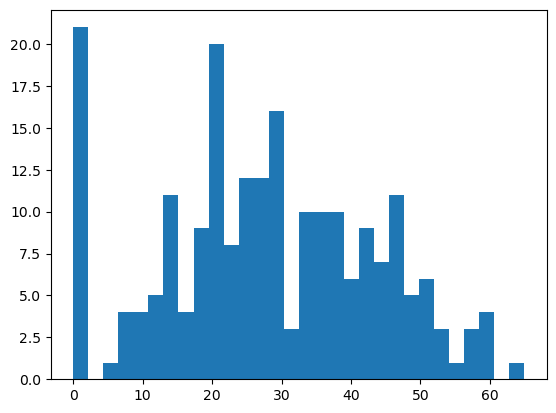

In [9]:
plt.hist(d2d.arcsecond, bins=30)

Make a histogram of just the good matches to see what the separations look like.

(array([4., 4., 2., 3., 1., 2., 2., 1., 0., 2.]),
 array([0.00690748, 0.04316211, 0.07941675, 0.11567139, 0.15192603,
        0.18818066, 0.2244353 , 0.26068994, 0.29694458, 0.33319922,
        0.36945385]),
 <BarContainer object of 10 artists>)

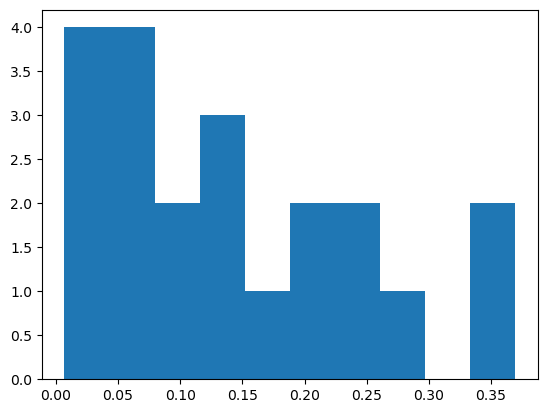

In [10]:
good_matches = d2d.arcsecond < 5
plt.hist(d2d.arcsecond[good_matches])

You may also want to remove any sources that have ambiguous pairings (within the limit you selected above) -- i.e. one gaia star matches multiple science sources or vice-versa

#### 2. Fitting a WCS

Now that we have found the stars that are in both our science image and our reference catalog, let's try to fit an improved WCS.

To do a simple version of this, use `astropy.wcs.utils.fit_wcs_from_points` to fit a WCS function. Use the optional argument `sip_degree` to choose what order of polynomial to use for the function. (Choosing zero should give something pretty close to the WCS we got from the fits file header.) The pixel values should come from our source catalog, and the sky coordinates should come from the Gaia catalog.

In [11]:
new_wcs = astropy.wcs.utils.fit_wcs_from_points((source_cat['x'][good_matches], source_cat['y'][good_matches]),
                                                gaia_skyCoord[id[good_matches]], sip_degree=3)

Now calculate the RA and Dec for the pixel coordinages in the input image and see if the separations between the science image and Gaia have improved.

(2.0843009876451175, 2.17691175599545)

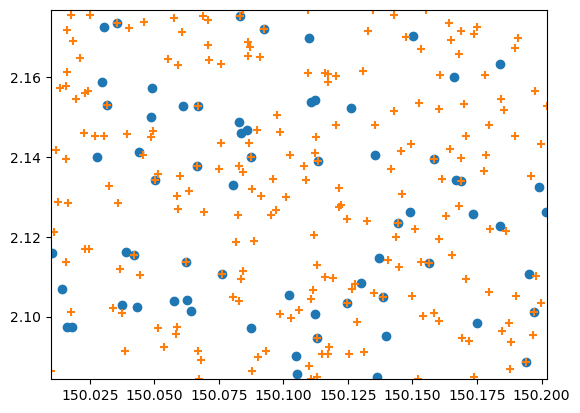

In [12]:
new_radec = new_wcs.pixel_to_world(source_cat['x'], source_cat['y'])
plt.scatter(gaia_skyCoord.ra, gaia_skyCoord.dec)
plt.scatter(new_radec.ra, new_radec.dec, marker='+')
plt.xlim(new_radec.ra.degree.min(), new_radec.ra.degree.max())
plt.ylim(new_radec.dec.degree.min(), new_radec.dec.degree.max())

(array([21.,  0.,  1.,  4.,  4.,  5., 11.,  4.,  9., 19.,  7., 14., 12.,
        15.,  4., 10., 10., 10.,  5., 10.,  7., 11.,  6.,  5.,  3.,  1.,
         4.,  3.,  0.,  1.]),
 array([1.17288385e-03, 2.16590442e+00, 4.33063595e+00, 6.49536748e+00,
        8.66009901e+00, 1.08248305e+01, 1.29895621e+01, 1.51542936e+01,
        1.73190251e+01, 1.94837567e+01, 2.16484882e+01, 2.38132197e+01,
        2.59779513e+01, 2.81426828e+01, 3.03074143e+01, 3.24721459e+01,
        3.46368774e+01, 3.68016089e+01, 3.89663405e+01, 4.11310720e+01,
        4.32958035e+01, 4.54605350e+01, 4.76252666e+01, 4.97899981e+01,
        5.19547296e+01, 5.41194612e+01, 5.62841927e+01, 5.84489242e+01,
        6.06136558e+01, 6.27783873e+01, 6.49431188e+01]),
 <BarContainer object of 30 artists>)

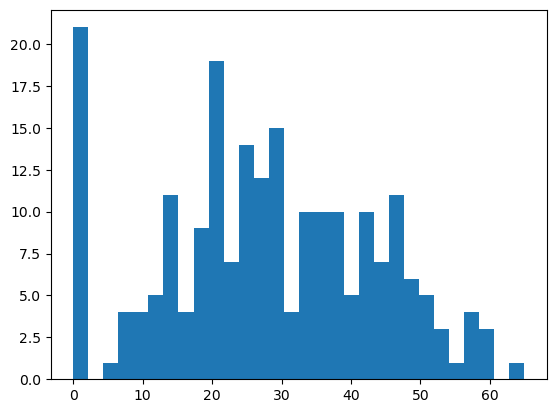

In [13]:
new_id, new_d2d, d3d = new_radec.match_to_catalog_sky(gaia_skyCoord)
plt.hist(new_d2d.arcsecond, bins=30)

(array([3., 4., 4., 3., 1., 3., 0., 0., 0., 3.]),
 array([0.00117288, 0.00275061, 0.00432834, 0.00590607, 0.0074838 ,
        0.00906152, 0.01063925, 0.01221698, 0.01379471, 0.01537244,
        0.01695016]),
 <BarContainer object of 10 artists>)

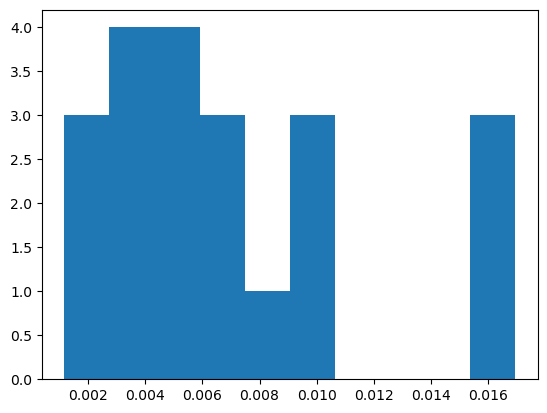

In [14]:
plt.hist(new_d2d[good_matches].arcsecond)

#### 3. Fit the WCS over the whole focal plane and look for camera-level effects

We are going to put the above steps together in a loop over all the detectors to get an improved WCS for each detector. 

In [60]:
source_files = glob('astrometry_data/1180_*.fits')
get_detector = re.compile(r'astrometry_data/1180_(\d+?).fits')
orig_wcs_dict = {}
new_wcs_dict = {}

# Save these quantities for later:
residuals = {}
pixel_errors = {}
for source_file in source_files:
    sources = fits.open(source_file)
    
    s = get_detector.search(source_file)
    detector = int(s.group(1))

    initial_wcs = wcs.WCS(sources[0].header)
    orig_wcs_dict[detector] = initial_wcs
    source_cat = sources[1].data

    source_coords = initial_wcs.pixel_to_world(source_cat['x'], source_cat['y'])

    id, d2d, d3d = source_coords.match_to_catalog_sky(gaia_skyCoord)
    good_matches = d2d.arcsecond < 2
    print(detector, good_matches.sum())

    new_wcs = astropy.wcs.utils.fit_wcs_from_points((source_cat['x'][good_matches], source_cat['y'][good_matches]),
                                                    gaia_skyCoord[id[good_matches]], sip_degree=3)
    new_wcs_dict[detector] = new_wcs

    # Save the fit residuals to use later:
    fitCoords = new_wcs.pixel_to_world(source_cat['x'][good_matches], source_cat['y'][good_matches])
    residuals[detector] = np.array([fitCoords.ra.degree - gaia_skyCoord[id[good_matches]].ra.degree,
                                    fitCoords.dec.degree - gaia_skyCoord[id[good_matches]].dec.degree]).T
    pixel_errors[detector] = {'xErr': source_cat['xErr'][good_matches],
                              'yErr': source_cat['yErr'][good_matches]}
sources = fits.open('astrometry_data/1180_42.fits')
source_cat = sources[1].data


54 2
15 13
42 21
39 22
81 19
97 15
78 17
58 23
19 12
35 20
3 11
62 9
74 14
23 14
22 11
75 19
2 17
63 21
34 25
18 17
59 18
96 18
79 11
80 22
38 16
43 21
14 10
55 14
103 12
48 21
33 12
5 17
64 25
72 20
25 20
52 11
13 13
44 15
87 27
68 11
91 19
29 10
28 21
90 14
86 18
8 12
69 8
45 12
12 17
53 12
24 26
73 13
4 26
65 18
32 18
49 23
27 16
70 18
66 16
7 16
89 13
31 17
101 15
93 10
85 18
46 13
11 14
50 15
51 21
10 19
47 15
84 12
92 14
100 16
30 16
67 18
6 17
88 16
71 13
26 26
95 13
83 11
40 20
17 21
56 19
21 14
76 17
99 18
60 11
1 17
37 15
36 15
61 9
0 16
77 11
98 23
20 18
57 14
16 18
41 16
82 15
94 15


Plot the difference in RA and Dec vs the simple wcs position, then look at this difference over the focal plane. Are there coherent distortions between detectors?

To do this, I recommend making a grid in x and y pixel values and calculating what RA and Dec those map to using the original and new WCSs for each detector. 

In [16]:
x_range = np.arange(0, 2048, 100)
y_range = np.arange(0, 4096, 100)
xgrid, ygrid = np.meshgrid(x_range, y_range)
xx = xgrid.ravel()
yy = ygrid.ravel()

all_ras, all_decs = [], []
all_ra_diffs, all_dec_diffs = [], []

for d in new_wcs_dict.keys():
    old_radec = orig_wcs_dict[d].pixel_to_world(xx, yy)
    new_radec = new_wcs_dict[d].pixel_to_world(xx, yy)

    all_ras.append(old_radec.ra.degree)
    all_decs.append(old_radec.dec.degree)

    all_ra_diffs.append((new_radec.ra - old_radec.ra).arcsecond)
    all_dec_diffs.append((new_radec.dec - old_radec.dec).arcsecond)

all_ras = np.concatenate(all_ras)
all_decs = np.concatenate(all_decs)
all_ra_diffs = np.concatenate(all_ra_diffs)
all_dec_diffs = np.concatenate(all_dec_diffs)

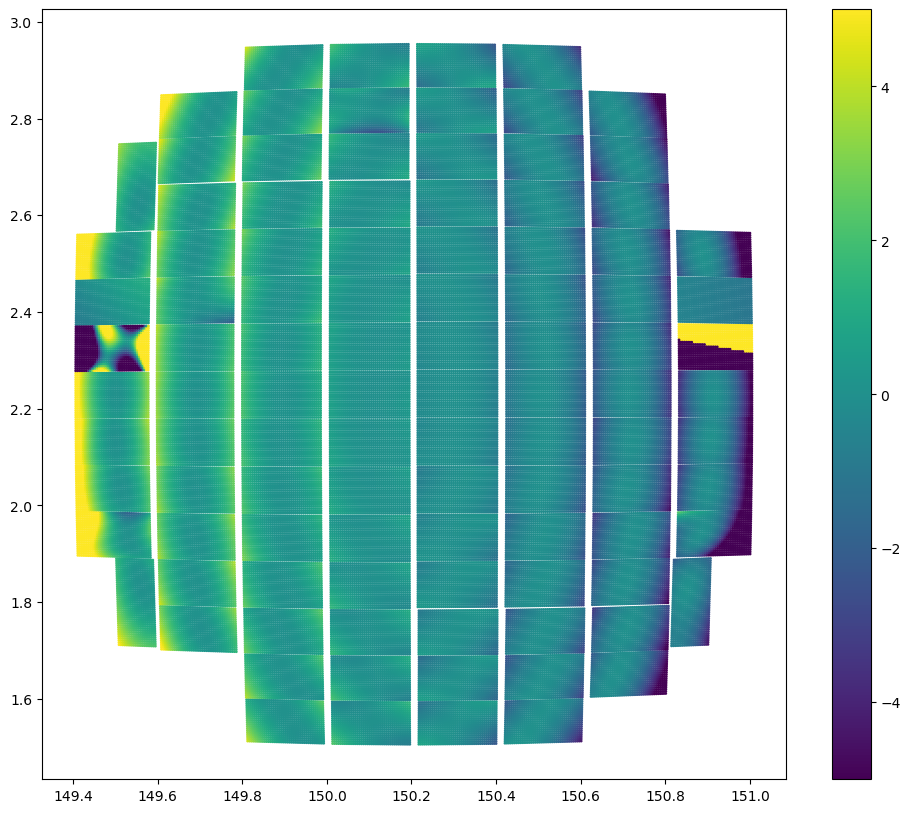

In [17]:
plt.figure(figsize=(12,10))
plt.scatter(all_ras, all_decs, c=all_ra_diffs, vmin=-5, vmax=5, s=1)
plt.colorbar()

You can see a rough radial pattern in the WCS distortions we fit. There are two detectors at the edges of the focal plane that have much bigger differences between the original WCS and the fit one. These are probably because there weren't enough stars to fit a good model.

#### 4. How good is the model? (Challenge problem)

Use the pixel scale matrix (the CD matrix) to approximate the WCS Jacobian and propagate the x and y errors to RA and Dec. You can use this equation for the error propagation:

$$ \mathbf{C}_{RA, Dec} = \mathbf{J} \mathbf{C}_{x, y} \mathbf{J}^T
$$

where $\mathbf{C}_{x, y}$ is the x,y covariance matrix, \mathbf{C}_{RA, Dec} is the covariance in RA and Dec, and \mathbf{J} is the Jacobian of the WCS transformation.


In [92]:
for source_file in source_files:
    sources = fits.open(source_file)[1].data

    s = get_detector.search(source_file)
    detector = int(s.group(1))

    wcs_jacobian = new_wcs_dict[detector].pixel_scale_matrix

    source_errors = pixel_errors[detector]
    nSources = len(source_errors['xErr'])
    # Fill the x-y covariance with the the x and y errors from the source catalog:
    pixel_covariance = np.zeros((nSources, 2, 2))
    pixel_covariance[:, 0, 0] = source_errors['xErr']**2 #xerr**2
    pixel_covariance[:, 1, 1] = source_errors['yErr']**2 #yerr**2
    # Note, we don't have the x-y measurement covariance, so we are going to leave those parts of the
    # covariance matrix zero.

    # Use the equation in the text above to get the ra-dec covariance:
    coord_covariance = np.array([wcs_jacobian.dot(pixel_cov.dot(wcs_jacobian.T)) for pixel_cov in
                                 pixel_covariance])
    # Invert the covariance matrix to get the weight matrix, which we can use to calculate the chi2:
    weight_matrices = np.array([np.linalg.inv(c) for c in coord_covariance])
    residuals_vector = residuals[detector]
    chi2s = 0
    for i in range(len(residuals_vector)):
        chi2 = residuals_vector[i].dot(weight_matrices[i].dot(residuals_vector[i].T))
        chi2s += chi2
    
    # I used a 3-degree SIP transform for my WCS, so that translates to 10 fit paramaters 
    # per coordinate. I subtract this from the number of fit points to get the number of degrees of freedom.
    dof = 2 * nSources - 2 * 10
    chi2_dof = chi2s / dof
    print(f'Detector {detector}: chi2={chi2s}, dof={dof} -> chi2/dof = {chi2_dof}')

Detector 54: chi2=-226.65625758064633, dof=-16 -> chi2/dof = 14.166016098790395
Detector 15: chi2=294.9150864148586, dof=6 -> chi2/dof = 49.152514402476434
Detector 42: chi2=2722.5592203493875, dof=22 -> chi2/dof = 123.75269183406307
Detector 39: chi2=2105.824479675194, dof=24 -> chi2/dof = 87.74268665313309
Detector 81: chi2=2554.9385512094373, dof=18 -> chi2/dof = 141.94103062274652
Detector 97: chi2=3250.3624868825027, dof=10 -> chi2/dof = 325.0362486882503
Detector 78: chi2=3190.7222804300072, dof=14 -> chi2/dof = 227.90873431642908
Detector 58: chi2=3163.3612042527097, dof=26 -> chi2/dof = 121.66773862510422
Detector 19: chi2=1304.2330859333151, dof=4 -> chi2/dof = 326.0582714833288
Detector 35: chi2=8839.434201513497, dof=20 -> chi2/dof = 441.9717100756749
Detector 3: chi2=220.68600607845497, dof=2 -> chi2/dof = 110.34300303922748
Detector 62: chi2=4864914.419292648, dof=-2 -> chi2/dof = -2432457.209646324
Detector 74: chi2=4395.090995237794, dof=8 -> chi2/dof = 549.3863744047243

/var/folders/th/ygf5gtmj2lg2zf4d786v924m0000gn/T/ipykernel_1299/1601961934.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  chi2_dof = chi2s / dof


I got $\chi^2 / dof$ ranging from around 20 to a few hundred, so the model is not great! (Remember a model that accurately describes the data should have $\chi^2 / dof\approx1$.) The next step in an analysis would be to try to see what the issues are causing these high values. I.e., are there some big measurement outliers that should be rejected, or do we need a different model that describes the data better?